<h2>Kuala Lumpur Property Prices</h2>
Clean the Property Prices for Kuala Lumpur

In [158]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers
from IPython import display
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.0f' % x)


df = pd.read_csv('./kl_property_data.csv')
df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3,2,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7,nan,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4,2,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
3,"Cheras, Kuala Lumpur",NaN,NaN,nan,nan,NaN,NaN,NaN
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3,2,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished


<h4>Check the Shape of the Data Frame</h4>

In [159]:
df.shape

(53883, 8)

<h1>Data Shaping / Cleaning<h2>
<h2>Location:</h2>
<h4>Clean the Locations Data</h4>
Clean the 'Kuala Lumpur' word, since all data belongs to the same city, also remove Capitalization inconsistencies

In [160]:
df['Location'] = df['Location'].str.lower() # convert all the cities to lower case 
df['Location'] = df['Location'].str.replace(r", kuala lumpur$", "") # remove ', kuala lumpur' from the area name
df['Location'].value_counts() # show unique values

mont kiara                           5897
klcc                                 5230
cheras                               4533
jalan klang lama (old klang road)    2854
setapak                              2710
                                     ... 
taming jaya                             1
canary residence                        1
jalan u-thant                           1
kemensah                                1
semarak                                 1
Name: Location, Length: 107, dtype: int64

<h2>Rooms:</h2>
<h4>Clean the Rooms</h4>
- split the '2+1' strings, convert to integers and add to get total area</br>
- also handle the words e.g. 'Studio'</br>
- also handle the 'Above' words</br>
- also Convert Rooms to integers

In [161]:
df.Rooms.value_counts() # check out the inconsistencies by getting unique values

3           14249
3+1          8070
2            5407
4            5018
4+1          4404
5+1          2340
1            2322
5            2065
2+1          1938
1+1          1191
6             937
Studio        874
6+1           807
4+2           479
3+2           477
5+2           410
7             358
7+1           237
2+2           132
8             125
6+             86
8+1            64
9              40
7+             32
10             25
9+1            14
8+             14
12              8
10+             8
1+2             8
20 Above        8
11              6
10+1            4
12+             4
11+1            3
13+             3
14              2
9+              2
16              2
18              1
13              1
15+             1
13+1            1
Name: Rooms, dtype: int64

In [162]:
def clean_trailing_plus(rooms):
    if rooms.endswith("+"):
        return int(rooms[:-1])         # remove the last character i.e. +
    if '+' in rooms:
        xx = rooms.split("+")          # split the string on '+' sign
        return int(xx[0]) + int(xx[1]) # add both sides of the string
    if 'Studio' in rooms:
        return 1                       # Studio flats are generally Single roomed
    if '20 Above' in rooms:
        return 20                      # assume 20 above is rated at 20 since the number is only 8 units, we can safely assume this
    else:
        return rooms                   # return the number of rooms if nothing above matches

df['Rooms']= df['Rooms'].astype(str).apply(clean_trailing_plus) # Apply cleaning operation

#Convert 'nan' in Rooms to 0 and convert Rooms to integer
df['Rooms'] = df['Rooms'].str.replace('nan', '0')
df['Rooms'] = pd.to_numeric(df['Rooms'])

print(df['Rooms'].value_counts())


3     14249
2      5407
4      5018
1      2322
5      2065
0      1706
6       937
7       358
8       125
9        40
10       25
12        8
11        6
16        2
14        2
18        1
13        1
Name: Rooms, dtype: int64


<h2>Car Parks:</h2>
<h4>Looks Okay</h4>
No Need Processing / Cleaning

In [163]:
df['Car Parks'].value_counts() # View Car Parks unique values

2     15314
1     13772
3      3838
4      1956
6       641
5       508
8        97
10       78
7        64
12        7
15        7
13        7
9         5
28        4
20        4
30        4
11        4
16        2
17        2
18        1
24        1
Name: Car Parks, dtype: int64

<h2>Bathrooms:</h2>
<h4>Looks Okay</h4>
No Need Processing / Cleaning

In [164]:
df['Bathrooms'].value_counts() # View Bathrooms unique values

2     21442
3      9496
4      6629
5      4787
1      4516
6      3245
7      1063
8       417
9       147
10       72
12       15
11       13
20       12
15        6
13        5
14        4
16        1
Name: Bathrooms, dtype: int64

<h2>Property Type:</h2>
<h4>Clean the Property Types Data</h4>
We ll try n group similar type of properties into a more simpler form of categories

In [165]:
def clean_property_types(propType):
    # Define the cleaned types without the extra details
    cleanTypes = [                     
        'Condominium',
        'Serviced Residence',
        'Terrace/Link House',
        'Bungalow',
        'Semi-detached House',
        'Apartment',
        'Residential Land',
        'Townhouse',
        'Flat',
        'Cluster House',
    ]

    # foreach type in cleanType, find the Property Type and return result
    for typ in cleanTypes:
        if typ in propType:
            return typ
        
# Apply the above function and view the results
df["Property Type"] = df["Property Type"].astype(str).apply(clean_property_types)
df["Property Type"].value_counts(dropna=False)

    

Condominium            23330
Serviced Residence     13453
Terrace/Link House      7811
Bungalow                3749
Semi-detached House     2162
Apartment               1677
Residential Land         744
Townhouse                550
Flat                     373
NaN                       25
Cluster House              9
Name: Property Type, dtype: int64

<h2>Size:</h2>
<h4>Clean the Size Data</h4>
- We ll split the Size column into Built_Type & Built_Size columns</br>
- we ll then clean the Built_Size column to strip out unnecessary strings e.g. 'sq. ft.' or 'sf' etc</br>
- then remove the original Size column since we have the data in two new columns

In [166]:

df.head() # check for inconsistencies


,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,klcc,"RM 1,250,000",nan,3,2,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,damansara heights,"RM 6,800,000",6,7,nan,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,dutamas,"RM 1,030,000",3,4,2,Condominium,"Built-up : 1,875 sq. ft.",Partly Furnished
3,cheras,NaN,0,nan,nan,None,NaN,NaN
4,bukit jalil,"RM 900,000",nan,3,2,Condominium,"Built-up : 1,513 sq. ft.",Partly Furnished


In [167]:
# define the function to split Size into an array of two differnt values
def split_property_size(size, tp=0):
    try:
        return size.split(":")[tp].strip()
    except AttributeError:
        return size


# define the function to Convert Built_Size into numeric value
def convert_built_size_numeric(bsize):
    try:
        if re.search(r"sq\.*\s*ft\.*", bsize) is None:
            return None
        bsize = bsize.replace(",", "")         #remove the commas in price
        bsize = bsize.replace("'", "")         # remove the ''' symbol in few records
        bsize = bsize.replace("sq. ft.", "")   # remove the sq. ft. from the records
        bsize = bsize.replace("sf", "")        # some records are in 'sf' format, clean them
        bsize = bsize.strip()
        bsize = bsize.lower()
        return int(bsize)
    except:
        return None

#create a new column with the buildup type
df["Built_Type"] = df['Size'].astype(str).apply(split_property_size, tp=0)

#create a new column with built size
df["Built_Size"] = df['Size'].apply(split_property_size, tp=1)

# convert built size into numeric value
df['Built_Size'] = df['Built_Size'].apply(convert_built_size_numeric)

# delete the 'Size' column
del df['Size']

df.head()


,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Furnishing,Built_Type,Built_Size
0,klcc,"RM 1,250,000",nan,3,2,Serviced Residence,Fully Furnished,Built-up,1335
1,damansara heights,"RM 6,800,000",6,7,nan,Bungalow,Partly Furnished,Land area,6900
2,dutamas,"RM 1,030,000",3,4,2,Condominium,Partly Furnished,Built-up,1875
3,cheras,NaN,0,nan,nan,None,NaN,nan,nan
4,bukit jalil,"RM 900,000",nan,3,2,Condominium,Partly Furnished,Built-up,1513


<h2>Price:</h2>
<h4>Clean the Price Data</h4>
- Remove null price values, these are only very small percentage of the total values
- Lets remove the 'RM' sign and the commas from the price</br>
- Since we cannot convert the price to integer because of null values, we will :</br>
    --- replace null values with Zeros</br>
    --- Convert the column to Integer values</br>

this exercise is to preseve NaN values so that we coudl impute these later in the process

In [168]:
(df['Price'].isnull().sum() / df.shape[0]) * 100  # calculate percentage of null values in Price

0.4602564816361375

In [169]:
# Drop NaN rows in Price column
df = df.dropna(subset=['Price'])

In [170]:
#Clean the Price column by stripping the label & commas
def price_cleanup(price):
    if pd.notna(price):
        price = price.replace("RM", "")
        price = price.replace(",", "")
        price = price.strip()
        return int(price)
    else:
        return None

# Apply the price_clean formula to clean up the pricing
df['Price'] = df['Price'].apply(price_cleanup)


In [171]:
df.isnull().sum()

Location             0
Price                0
Rooms            21514
Bathrooms         1962
Car Parks        17441
Property Type        0
Furnishing        6856
Built_Type           0
Built_Size        6912
dtype: int64

<h2>Furnishing - Impute Values:</h2>
<h4>Replace NaN with Unknown</h4>

In [172]:
# impute the Furnishing column

df['Furnishing'] = df['Furnishing'].fillna('Unknown')

<h2>Remove Nulls:</h2>
<h4>Delete Rows with Null Values</h4>
delete all rows with null values in either 'Rooms', 'Build_Size', 'Car Parks', or 'Bathrooms' columns

In [173]:
df.dropna(subset=['Rooms', 'Built_Size', 'Car Parks', 'Bathrooms'], inplace=True)

In [174]:
df.isnull().sum()  # will show zero nulls

Location         0
Price            0
Rooms            0
Bathrooms        0
Car Parks        0
Property Type    0
Furnishing       0
Built_Type       0
Built_Size       0
dtype: int64

<h2>Eye-Ball data anomalies:</h2>
<h4>Lets eye ball the data for anomalies</h4>

In [175]:
# EyeBalling the data anomalies
df = df[df.Price != 1980000000] # remove the errornous price row
df = df[df.Location != 'singapore'] # remove singapore entry from kuala lumpur data

In [176]:
df['Price'].value_counts(dropna=False)

450000     316
500000     300
650000     291
550000     280
600000     252
          ... 
947000       1
499800       1
4900         1
1745000      1
1426000      1
Name: Price, Length: 1896, dtype: int64

<h2>Analytic Charts:</h2>
<h4>Lets create few plots and charts for our analysis</h4>

matplotlib.axes._subplots.AxesSubplot

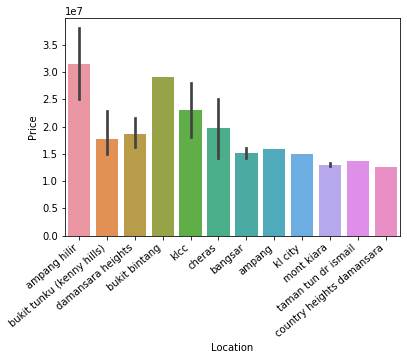

In [179]:
# plt.figure(figsize=(15,10))
chart = sns.barplot(data=df.sort_values(by="Price", ascending=False).head(50), x='Location', y="Price" )
# plt.show()
chart.set_xticklabels(chart.get_xticklabels(), rotation=40, horizontalalignment='right')
type(chart)

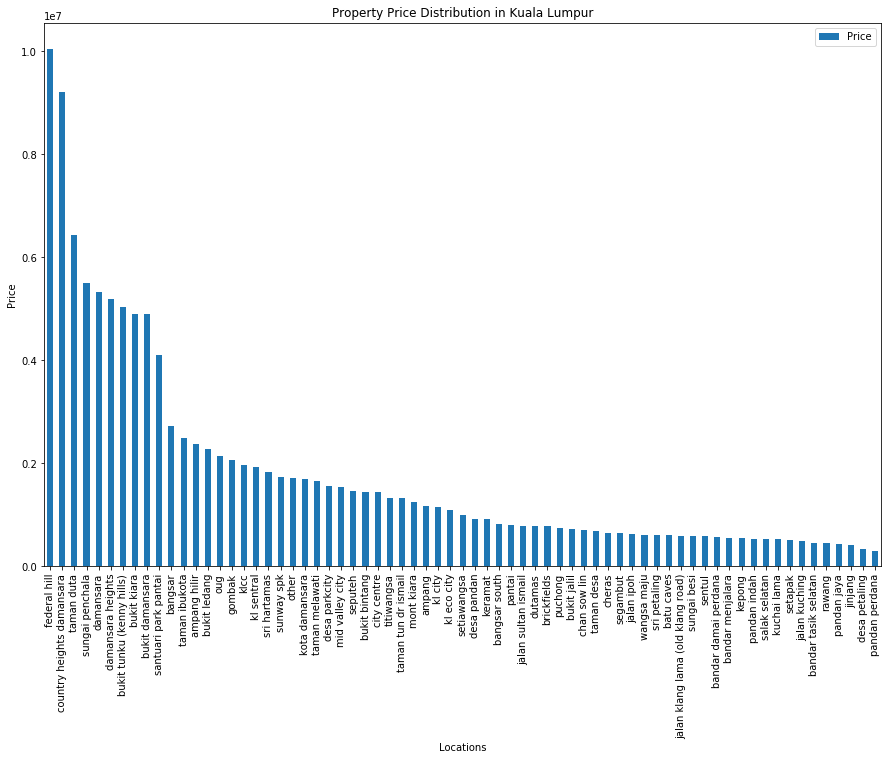

In [180]:
# most expensive area in KL by mean pricing
all_property_prices = df.groupby('Location')['Price'].mean().sort_values(ascending=False)

ax = all_property_prices.plot(kind='bar', title="Property Price Distribution in Kuala Lumpur", figsize=(15,10), legend=True, fontsize=10, rot=90)
ax.set_xlabel("Locations", fontsize=10)
ax.set_ylabel("Price", fontsize=10)
plt.show()

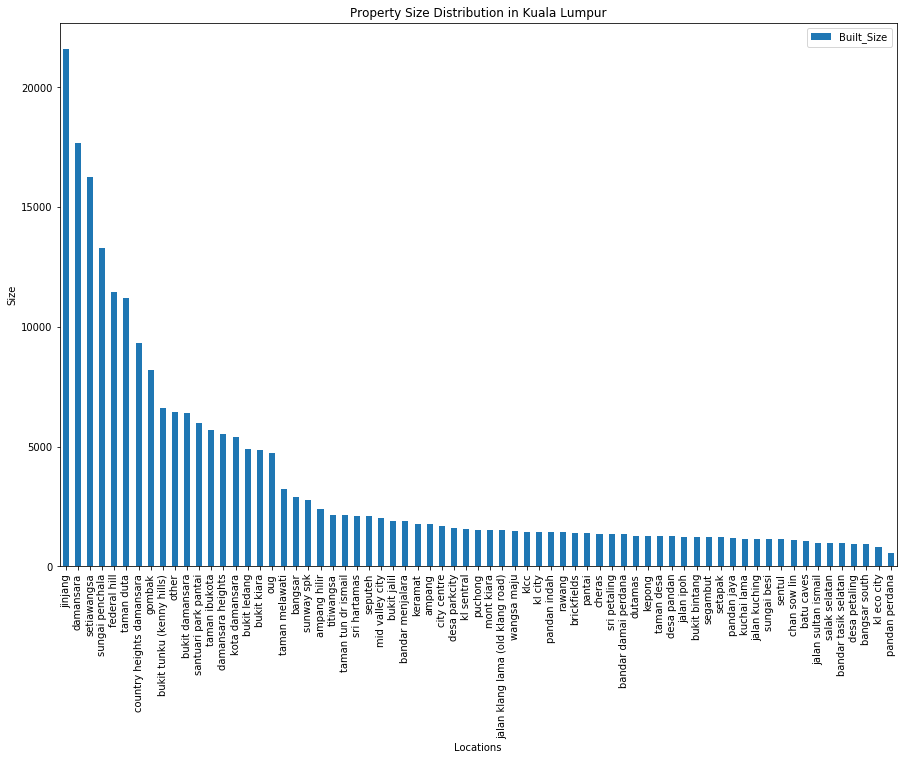

In [181]:
# highly sqft per area
all_property_sqft = df.groupby('Location')['Built_Size'].mean().sort_values(ascending=False)

bx = all_property_sqft.plot(kind='bar', title="Property Size Distribution in Kuala Lumpur", figsize=(15,10), legend=True, fontsize=10, rot=90)
bx.set_xlabel("Locations", fontsize=10)
bx.set_ylabel("Size", fontsize=10)
plt.show()

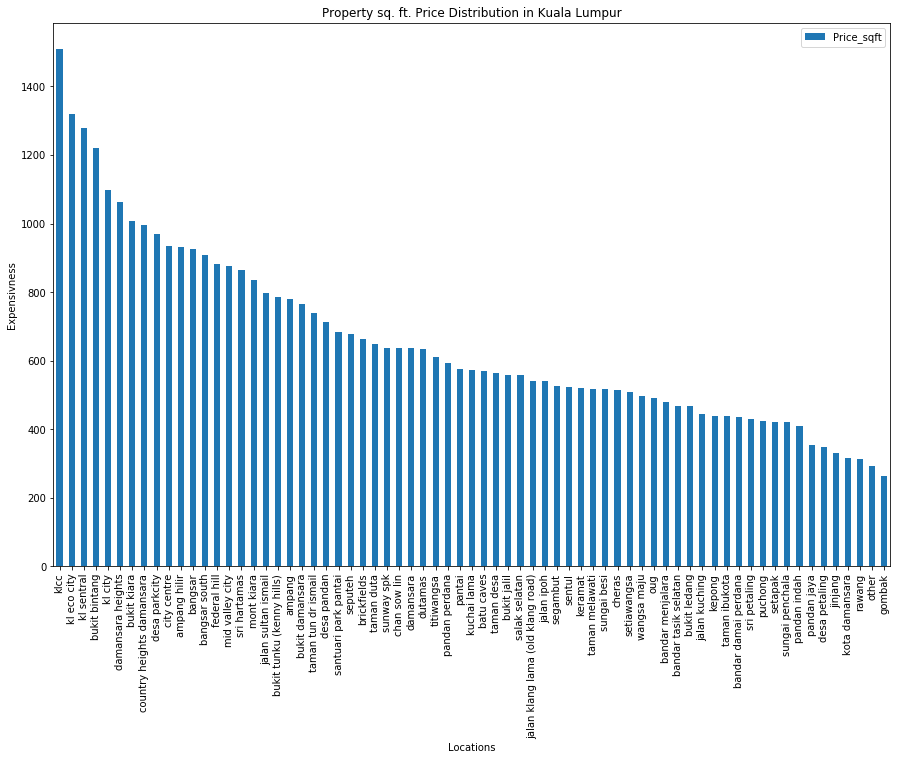

In [182]:

#  create price per sqft
df['Price_sqft'] = df['Price'] / df['Built_Size']

# most expensive area by price per sqft
dfc = df.copy(deep=True)

# since we have infinite values in the data, for simplicity sake, we will drop these values
dfc = dfc.replace([np.inf, -np.inf], np.nan).dropna(subset=["Price_sqft"], how="all") # replace infinite values with nan

all_property_price_sqft = dfc.groupby('Location')['Price_sqft'].mean().sort_values(ascending=False)

cx = all_property_price_sqft.plot(kind='bar', title="Property sq. ft. Price Distribution in Kuala Lumpur", figsize=(15,10), legend=True, fontsize=10, rot=90)
cx.set_xlabel("Locations", fontsize=10)
cx.set_ylabel("Expensivness", fontsize=10)
plt.show()

In [183]:


# price per room
df['Price_room'] = df['Price'] / df['Rooms']

# rooms per sq ft (larger rooms)
df['Rooms_sqft'] = df['Built_Size'] / df['Rooms']